In [1]:
import selfies as sf
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import torch
import torch.nn as nn
import random, glob, os
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit import Chem
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from baseline_model import BaselineVAE

In [2]:
df = pd.read_csv('../smiles_selfies_full.csv')
df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [PAD, SOS, EOS] + vocab
#         0,   1,   2, ....

tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

def full_molecule_tokens_to_ids(tokens, tok2id):
    # Add SOS and EOS tokens
    return np.array([1] + [tok2id[t] for t in tokens] + [2])

df['token_ids'] = df['tokens'].apply(lambda toks: full_molecule_tokens_to_ids(toks, tok2id))
df['lenghts'] = df['token_ids'].apply(len)

sequences = df['token_ids'].tolist()
max_len = max(len(seq) for seq in sequences)
padded_data = np.zeros((len(sequences), max_len), dtype=sequences[0].dtype)

for i, seq in enumerate(sequences):
    padded_data[i, :len(seq)] = seq

data = padded_data
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print(f"Data shapes: Train {train_data.shape}, Val {val_data.shape}, Test {test_data.shape}")

Data shapes: Train (635522, 77), Val (79440, 77), Test (79441, 77)


In [3]:
device = 'cuda'
training_dict = torch.load("trained_models/vae_lat256_beta0.01.pt", map_location=device)
latent_size = training_dict['latent_size']
hidden_size = training_dict['hidden_size']
embed_size = training_dict['embed_size']
print(f"hidden_size={hidden_size}, embed_size={embed_size}, latent_size={latent_size}")

hidden_size=512, embed_size=128, latent_size=256


In [4]:
model = BaselineVAE(vocab_size=len(vocab), max_len=train_data.shape[-1], embed_size=embed_size, hidden_size=hidden_size, latent_size=latent_size).to(device)
model.load_state_dict(training_dict['state_dict'])

<All keys matched successfully>

### Accuracies

In [5]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(id)] for id in tokens]
    return str(selfie_tokens)

def get_accuracy_samples(model, data, pad_id=0, num_samples=5):
    model.eval()    
    for _ in range(num_samples):
        i = np.random.randint(0, len(data))
        x = data[i]
        x = x[np.newaxis, :]
        logits, mu, logvar = model.encode_sequence(x)
        x_rec = torch.argmax(logits, dim=-1)
        acc, pad = 0, 0
        j = 0
        x = x.squeeze(0)
        x_rec = x_rec.squeeze(0)
        while x[j] != pad_id:
            pad += 1
            if x[j] == x_rec[j]:
                acc += 1
            j+=1
        acc = acc / pad
        print(f"real: {tokens_to_selfie(x)}")
        print(f"rec: {tokens_to_selfie(x_rec)}")
        print(f"accuracy: {acc}")
        print('------------------------------')

In [7]:
get_accuracy_samples(model, test_data, pad_id=0, num_samples=5)

real: ['<SOS>', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[Branch1]', '[=Branch2]', '[C]', '[N]', '[C]', '[=N]', '[C]', '[=N]', '[Ring1]', '[Branch1]', '[Branch1]', '[=Branch2]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[N]', '[Branch1]', '[C]', '[C]', '[O]', '[Ring2]', '[Ring1]', '[C]', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
rec: ['<SOS>', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[Branch1]', '[=Branch2]', '[C]', '[N]', '[C]', '[=N]', '[C]', '[=N]', '[Ring1]', '[Branch1]', '[Branch1]', '[=Branch2]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[N]', '[Branch1]', '[C]', '[C]', '[O]

In [8]:
def get_accuracy(model, data, pad_id=0, batch_size=64):
    model.eval()
    all_accs = []
    perfect = 0
    with torch.no_grad():
        for b in range(0, len(data), batch_size):
            batch = data[b : b + batch_size]              
            batch = torch.tensor(batch, device='cuda')  
            logits, mu, logvar = model.encode_sequence(batch)   
            preds = torch.argmax(logits, dim=-1)                
            mask = (batch != pad_id)                            
            correct = (batch == preds) & mask                   
            acc = correct.sum(dim=1).float() / mask.sum(dim=1)
            all_accs.extend(acc.cpu().tolist())
            perfect += (acc == 1).sum().item()
    print(f"reconstructed correctly {perfect} out of {len(data)} molecules")
    print(f"correct rec %: {perfect*100 / len(data):.2f}%")
    print(f"mean accuracy: {np.mean(all_accs)*100:.2f}%")

In [9]:
get_accuracy(model, val_data)

reconstructed correctly 71507 out of 79440 molecules
correct rec %: 90.01%
mean accuracy: 99.62%


### Visualisations

In [10]:
n_samples = 100000
vis_data = data[:n_samples]
logits, mu, logvar = model.encode_sequence(data, batch_size=64)
z = mu
z.cpu().numpy()
z.shape

torch.Size([794403, 256])

In [11]:
n_samples = 5000
idxs = np.random.choice(z.shape[0], size=n_samples, replace=False)
z_sample = z[idxs]
len_labels = len_labels = np.array(df['lenghts'])[idxs]
z_sample.shape

torch.Size([5000, 256])

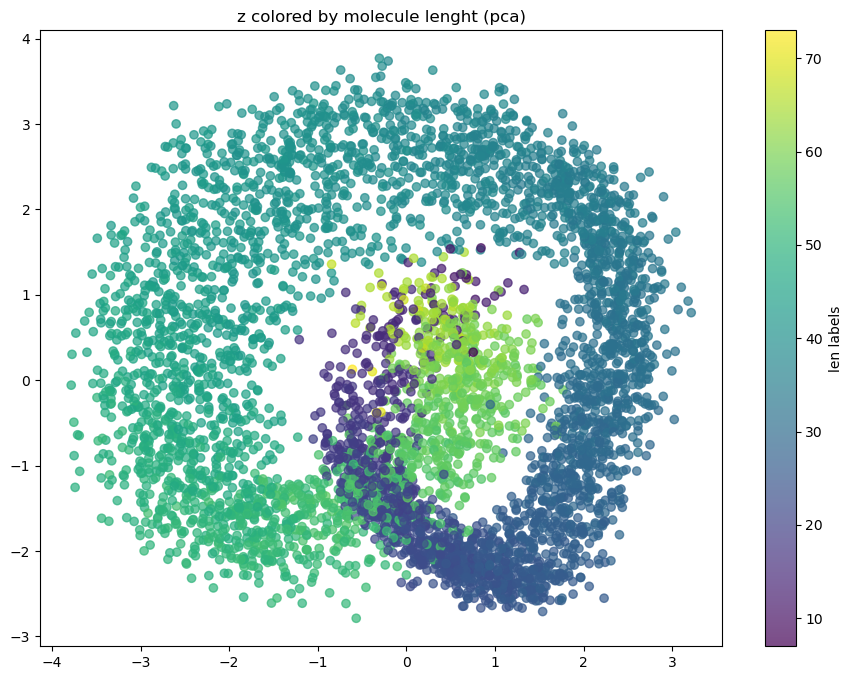

In [12]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (pca)')
plt.colorbar(label='len labels')
plt.show()

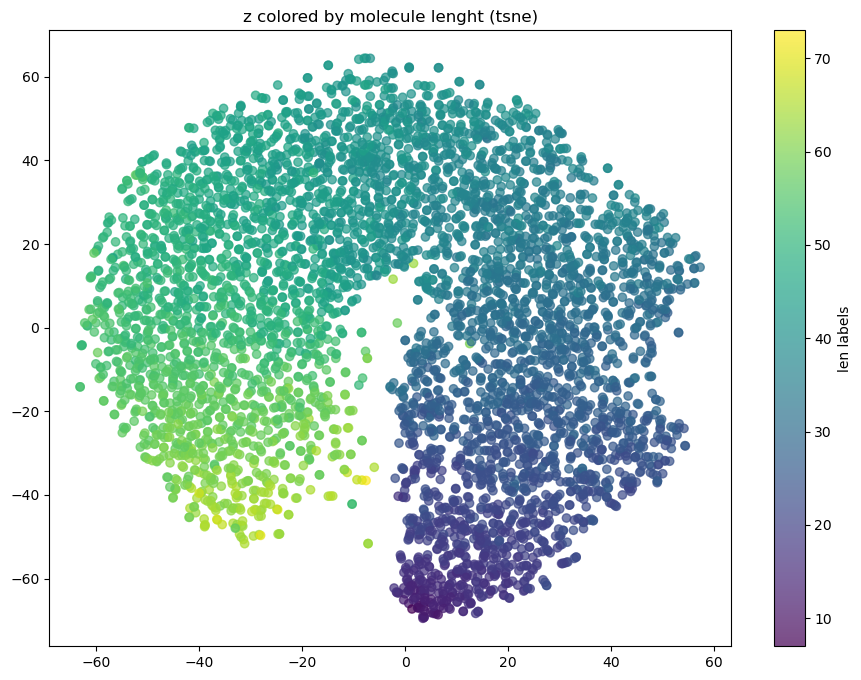

In [13]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (tsne)')
plt.colorbar(label='len labels')
plt.show()

In [14]:
oxygen_labels = df['selfies'].apply(lambda x: 1 if 'O' in x else 0)[idxs]

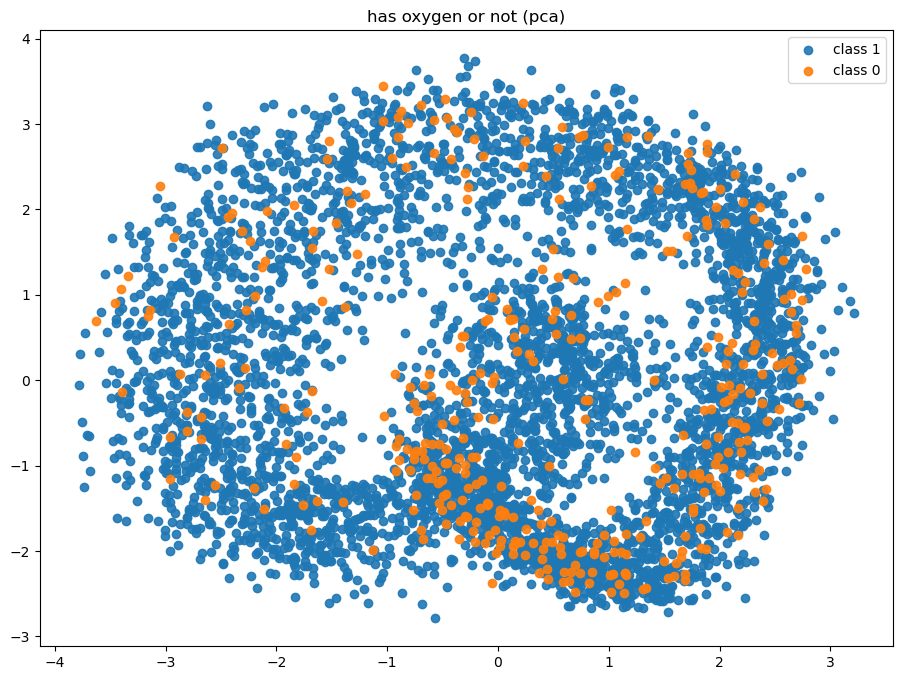

In [15]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (pca)')
plt.legend()
plt.show()

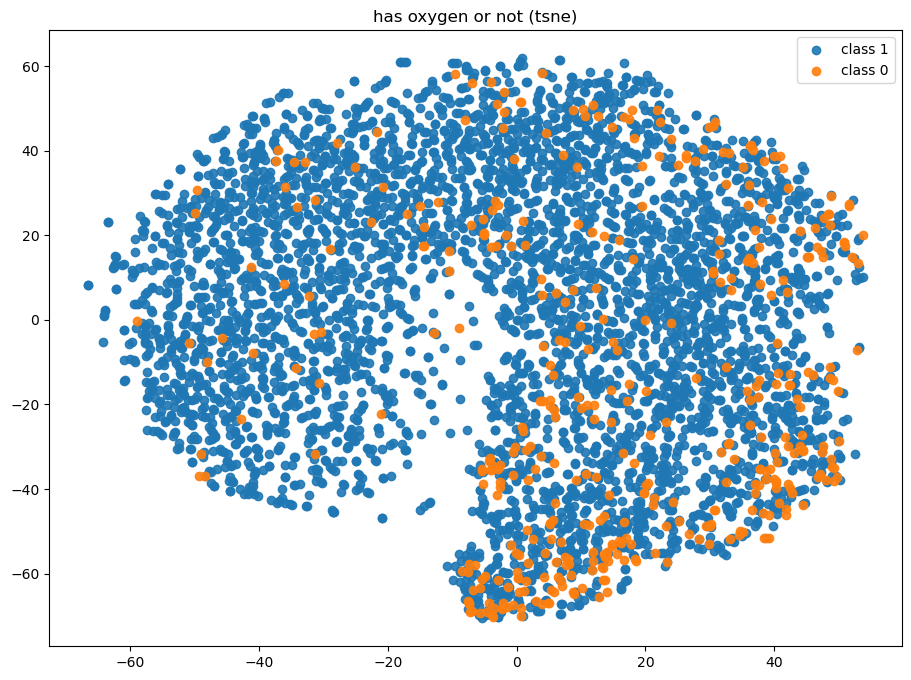

In [24]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (tsne)')
plt.legend()
plt.show()

In [16]:
carbon_label =  df['selfies'].apply(lambda x: x.count('C'))[idxs]

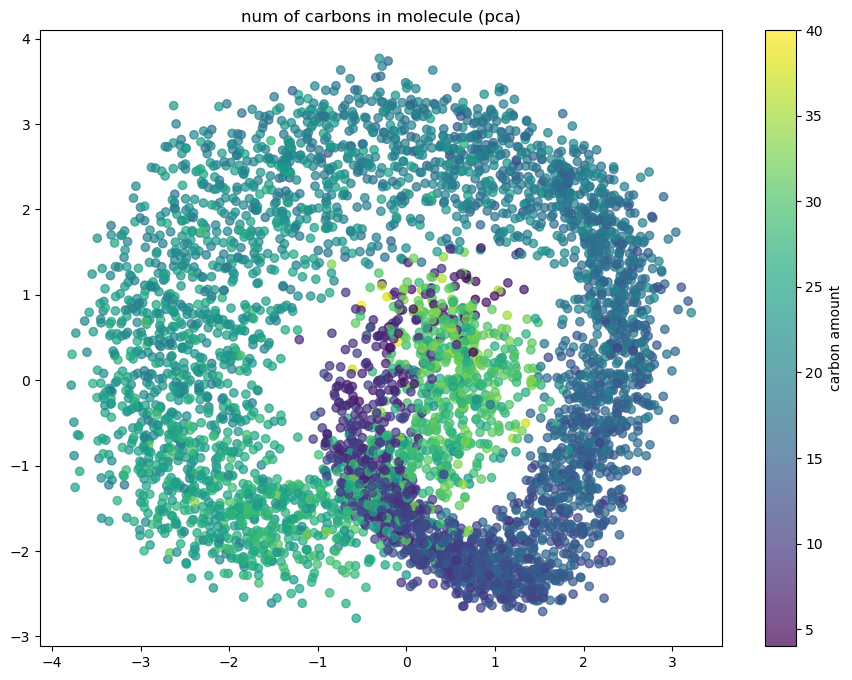

In [17]:
pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=carbon_label, cmap="viridis", alpha=0.7)
plt.title(label='num of carbons in molecule (pca)')
plt.colorbar(label='carbon amount')
plt.show()

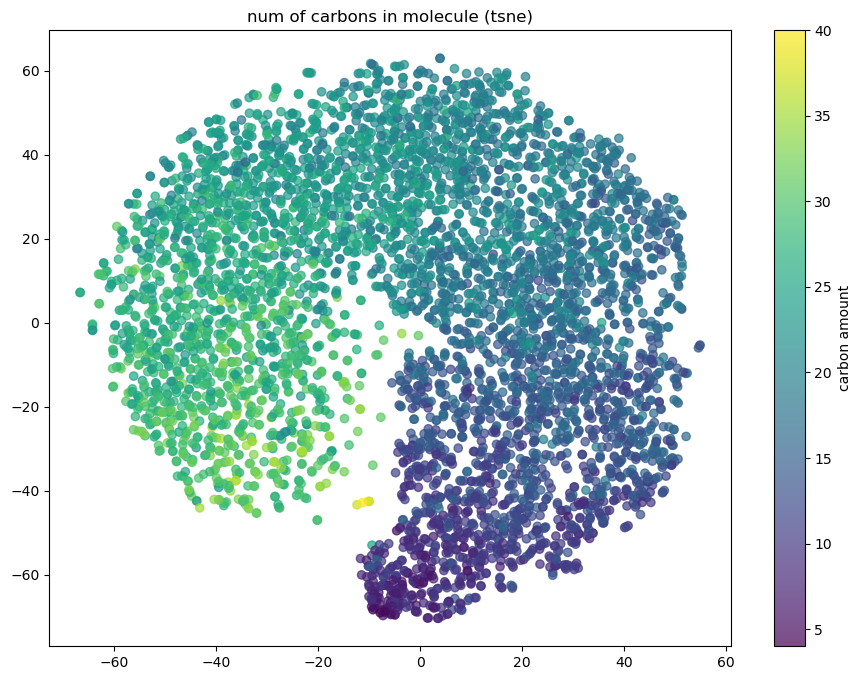

In [27]:
pca_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=carbon_label, cmap="viridis", alpha=0.7)
plt.title(label='num of carbons in molecule (tsne)')
plt.colorbar(label='carbon amount')
plt.show()

### Validity of Latent Space

In [18]:
def cleaned_selfie(tokens):
    cleaned = []
    for tok in tokens:
        if tok == "<SOS>" or tok == "PAD":
            pass
        if tok == "<EOS>":
            break
        else:
            cleaned.append(tok)
    return cleaned

def sample_and_check(model, latent_size=128, n=1000):
    z = torch.randn((n, latent_size), device='cuda')
    with torch.no_grad():
        model.eval()
        logits = model.decode(z)
    preds = torch.argmax(logits, dim=-1).cpu().numpy()
    valid_pct = 0
    for ids in preds:
        toks = [id2tok[t] for t in ids]
        toks = cleaned_selfie(toks)
        selfie = "".join(toks).replace("<PAD>", "")
        try:
            smiles = sf.decoder(selfie)
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                valid_pct += 1
        except:
            pass
    return z, valid_pct / n

In [19]:
z, valid_pct = sample_and_check(model, latent_size=latent_size)
z = z.cpu().numpy()
print(f'validality % of latent space: {valid_pct*100}%')

validality % of latent space: 99.6%


In [29]:
def count_duplicates(lst):
    if not lst:
        return [], []
    unique = [lst[0]]
    counts = [1]
    for x in lst[1:]:
        if x == unique[-1]:
            counts[-1] += 1
        else:
            unique.append(x)
            counts.append(1)
    return unique, counts

def latent_traversal(model, x, dim=0, steps=40, max_delta=3.0):
    model.eval()
    with torch.no_grad():
        mu, logvar = model.encode(x.unsqueeze(0).to(device))
    z = mu[0]
    xs = np.linspace(-max_delta, max_delta, steps)
    zs = []
    valids = []

    for s in xs:
        z_new = z.clone()
        z_new[dim] += s
        logits = model.decode(z_new.unsqueeze(0))
        ids = logits.argmax(dim=-1)[0].cpu().numpy()

        toks = [id2tok[t] for t in ids]
        toks = cleaned_selfie(toks)
        selfies_str = "".join(toks).replace("<PAD>", "")
        zs.append(z_new.cpu().numpy())

        try:
            smiles = sf.decoder(selfies_str)
            print(smiles)
            valids.append(Chem.MolFromSmiles(smiles) is not None)
        except:
            valids.append(False)

    plt.plot(xs, valids)
    plt.title(f"Validity when traversing latent dim={dim}")
    plt.show()

def latent_random_traversal(model, data, steps=40, sigma=0.1, n_samples=5000):
    model.eval()
    x = torch.tensor(data[np.random.randint(0, len(data))])
    #x = torch.zeros_like(x)
    with torch.no_grad():
        mu, logvar = model.encode(x.unsqueeze(0).to(device))
    z = mu

    zs = []
    valids = []
    valid_smiles = []
    
    logits = model.decode(z.unsqueeze(0))
    ids = logits.argmax(dim=-1)[0].cpu().numpy()
    toks = [id2tok[t] for t in ids]
    toks = cleaned_selfie(toks)
    selfies_str = "".join(toks).replace("<PAD>", "")
    smiles = sf.decoder(selfies_str)
    print(f'start smiles: {smiles}')

    z_new = z.clone()
    for s in range(steps):
        z_new += torch.randn_like(z_new) * sigma
        logits = model.decode(z_new.unsqueeze(0))
        ids = logits.argmax(dim=-1)[0].cpu().numpy()

        toks = [id2tok[t] for t in ids]
        toks = cleaned_selfie(toks)
        selfies_str = "".join(toks).replace("<PAD>", "")
        zs.append(z_new.squeeze_(0).cpu().numpy())

        try:
            smiles = sf.decoder(selfies_str)
            valid_smiles.append(smiles)
            valids.append(Chem.MolFromSmiles(smiles) is not None)
        except:
            #smiles = sf.decoder(selfies_str)
            valids.append(False)

    unique, counts = count_duplicates(valid_smiles)
    for i in range(len(unique)):
        print(unique[i], counts[i])

    plt.plot(np.arange(steps), valids)
    plt.title(f"Validity when random traversing")
    plt.show()
    idxs = np.random.randint(0, len(data), size=n_samples)
    logits, mu, logvar = model.encode_sequence(val_data, batch_size=64)
    z = mu
    z = z.cpu().numpy().tolist()
    zs += z
    pca_z = PCA(n_components=2).fit_transform(zs)
    plt.scatter(pca_z[:steps, 0], pca_z[:steps, 1], alpha=0.5)
    plt.scatter(pca_z[steps:, 0], pca_z[steps:, 1], alpha=0.7)
    plt.show()

CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C(Br)C(=O)O)=N1
CCCCCCCCCCCCN1N=NC(C

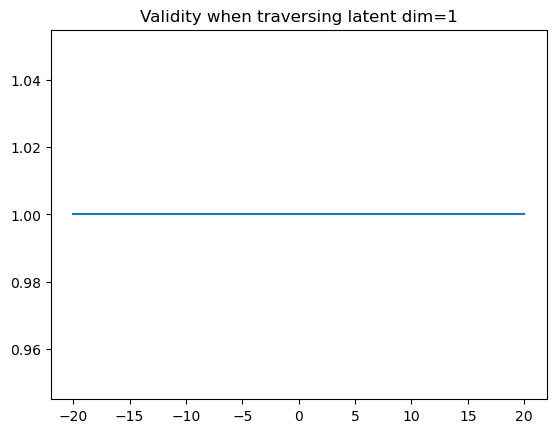

In [30]:
latent_traversal(model, torch.tensor(train_data[np.random.randint(0,len(train_data))]), dim=1, steps=100, max_delta=20)

start smiles: CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=N3)=COC=2C1
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=N3)=COC=2C1 105
CC1(C)CC(=O)C=2C(C(=O)NC3=NC=C(N4CCNCC4)C=N3)=COC=2C1 2
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=N3)=COC=2C1 2
CC1(C)CC(=O)C=2C(C(=O)NC3=NC=C(N4CCNCC4)C=N3)=COC=2C1 1
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=N3)=COC=2C1 8
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=C3)=COC=2C1 1
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=N3)=COC=2C1 2
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=C3)=COC=2C1 1
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=N3)=COC=2C1 7
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=C3)=COC=2C1 1
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=N3)=COC=2C1 3
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=C3)=COC=2C1 3
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=N3)=COC=2C1 1
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=C3)=COC=2C1 3
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=N3)=COC=2C1 5
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4CCNCC4)C=C3)=COC=2C1 2
CC1(C)CC(=O)C=2C(C(=O)NC3=CC=C(N4C

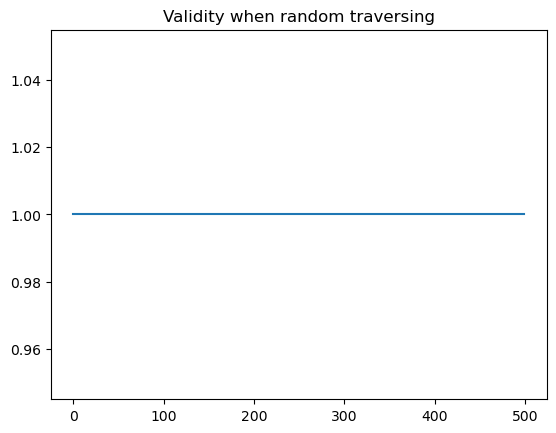

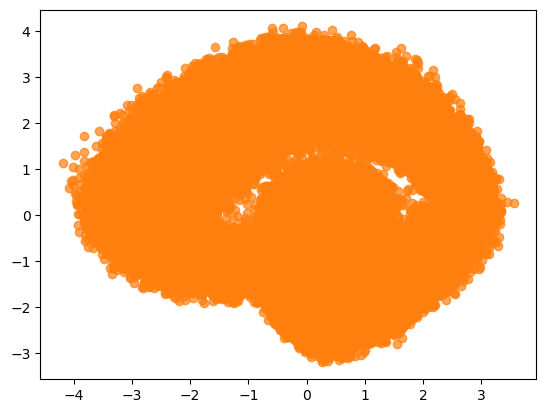

In [35]:
latent_random_traversal(model, val_data, steps=500, sigma=0.01, n_samples=1000)

### 3D plots

In [33]:
from sklearn.decomposition import PCA
import plotly.express as px

# PCA to 3 components
pca = PCA(n_components=3)
pca_z = pca.fit_transform(z_sample)

fig = px.scatter_3d(
    x=pca_z[:,0],
    y=pca_z[:,1],
    z=pca_z[:,2],
    color=len_labels,
    color_continuous_scale='Viridis',
    opacity=0.7,
    title='z colored by molecule length (PCA 3D)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700
)

fig.show(renderer="browser")   # ← fix: open plot in browser


In [34]:
# PCA to 3 components
pca = PCA(n_components=3)
pca_z = pca.fit_transform(z_sample)

fig = px.scatter_3d(
    x=pca_z[:,0],
    y=pca_z[:,1],
    z=pca_z[:,2],
    color=carbon_label,
    color_continuous_scale='Viridis',
    opacity=0.7,
    title='z colored by carbon count (PCA 3D)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700
)

fig.show(renderer="browser")   # ← fix: open plot in browser

In [ ]:
# PCA to 3 components
pca = PCA(n_components=3)
pca_z = pca.fit_transform(z_sample)

fig = px.scatter_3d(
    x=pca_z[:,0],
    y=pca_z[:,1],
    z=pca_z[:,2],
    color=carbon_label,
    color_continuous_scale='Viridis',
    opacity=0.7,
    title='z colored by carbon count (PCA 3D)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700
)

fig.show(renderer="browser")   # ← fix: open plot in browser

In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# PCA to 3 components
pca = PCA(n_components=3)
pca_z = pca.fit_transform(z_sample)

fig = go.Figure()

unique_classes = np.unique(oxygen_labels)[::-1]

for cls in unique_classes:
    idx = (oxygen_labels == cls)

    fig.add_trace(go.Scatter3d(
        x=pca_z[idx, 0],
        y=pca_z[idx, 1],
        z=pca_z[idx, 2],
        mode='markers',
        name=f"class {cls}",
        opacity=0.9,
        marker=dict(size=3)   # you can adjust size here
    ))

fig.update_layout(
    title="PCA 3D scatter by oxygen class",
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700
)

fig.show(renderer="browser")
